In [1]:
import sys
import os
sys.path.append('..')


import torch

from manga_ocr.utils import get_path_project_dir
from manga_ocr.utils.pytorch_model import get_total_parameters_count

# Load/Prepare model

In [2]:
from manga_ocr.models import localization

model_path = get_path_project_dir('data/output/models/localization.bin')
model = localization.load_or_create_default_model(model_path)
    
print(model)

ConvUnet(
  (down_conv_3): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_2): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_1): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stri

In [3]:
print(model.preferred_image_size)
print(get_total_parameters_count(model))

(500, 500)
197602


## Load/Prepare Dataset

In [4]:
from manga_ocr.models.localization.localization_dataset import LocalizationDataset

generate_manga_dataset_path = get_path_project_dir('data/output/generate_manga_dataset')
generate_manga_dataset = LocalizationDataset.load_generated_manga_dataset(
    generate_manga_dataset_path, image_size=model.preferred_image_size)
print('generate_manga_dataset', len(generate_manga_dataset))

generate_manga_dataset 4000


In [5]:
manga_line_annotated_dataset_path = get_path_project_dir('data/manga_line_annotated')
manga_line_annotated_dataset = LocalizationDataset.load_line_annotated_manga_dataset(
    manga_line_annotated_dataset_path, image_size=model.preferred_image_size)
print('manga_line_annotated_datasetaset', len(manga_line_annotated_dataset))

manga_line_annotated_datasetaset 36


In [6]:
validation_dataset = generate_manga_dataset.subset(to_idx=100)
training_dataset = generate_manga_dataset.subset(from_idx=100)

print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 100
training_dataset 3900


In [7]:
real_training_dataset = manga_line_annotated_dataset.subset(from_idx=15)

# Training

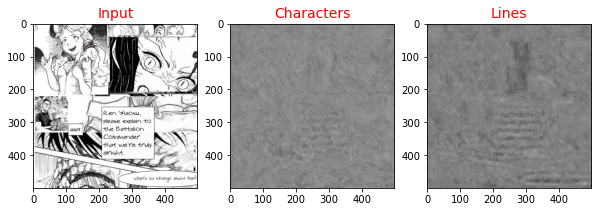

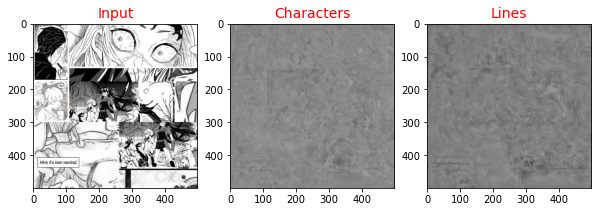

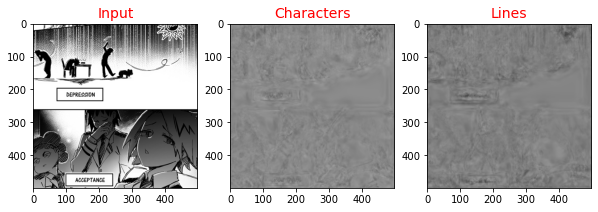

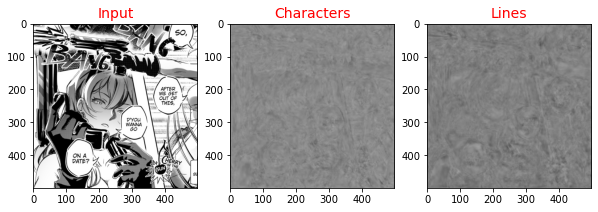

In [8]:
from manga_ocr.models.localization.train import train
from manga_ocr.utils.ploting import plot_losses, show_images
from IPython.display import clear_output

def show_example(model, img):
    mask_char, mask_line = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line], 
        texts=['Input', 'Characters', 'Lines'], 
        figsize=(10, 10), num_col=3
    )


show_example(model, training_dataset.images[0])
show_example(model, validation_dataset.images[0])
show_example(model, manga_line_annotated_dataset.images[3])
show_example(model, manga_line_annotated_dataset.images[10])

In [9]:
def save_and_report(i_epoch, train_losses, val_losses):
    clear_output()
    plot_losses(train_losses, val_losses)
    show_example(model, validation_dataset.images[0])
    show_example(model, manga_line_annotated_dataset.images[3])
    show_example(model, manga_line_annotated_dataset.images[10])
    
    torch.save(model, model_path)

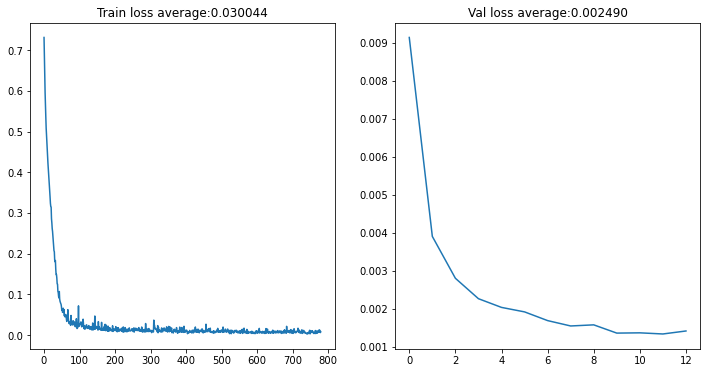

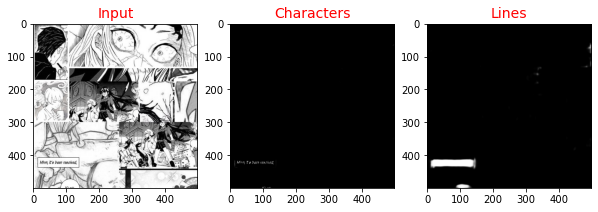

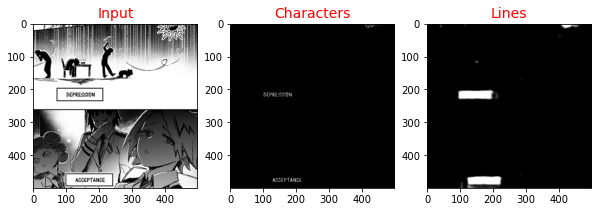

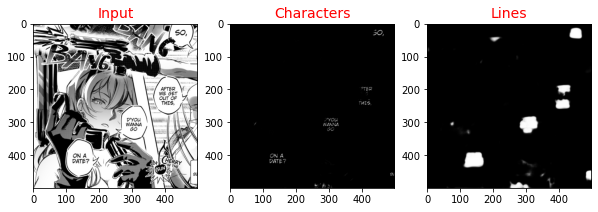

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [59:04<00:00,  1.10it/s, train_loss=0.00601, validate_loss=0.00142]


([0.7310925722122192,
  0.683037281036377,
  0.6366541385650635,
  0.5952932238578796,
  0.5608035326004028,
  0.5355474352836609,
  0.5084887742996216,
  0.4904428720474243,
  0.4727150797843933,
  0.45327797532081604,
  0.43699368834495544,
  0.4222612977027893,
  0.4074958562850952,
  0.39317265152931213,
  0.37776637077331543,
  0.3670770823955536,
  0.35434120893478394,
  0.33900296688079834,
  0.3234529495239258,
  0.31553345918655396,
  0.3144247829914093,
  0.28581565618515015,
  0.2754870057106018,
  0.2616046071052551,
  0.2543964087963104,
  0.2421014904975891,
  0.2297421395778656,
  0.21774405241012573,
  0.20714884996414185,
  0.2046310007572174,
  0.1844141185283661,
  0.17999327182769775,
  0.18302935361862183,
  0.16179615259170532,
  0.14835655689239502,
  0.14882725477218628,
  0.139925017952919,
  0.12577995657920837,
  0.12489812076091766,
  0.10720516741275787,
  0.10417535901069641,
  0.09479548037052155,
  0.09109511971473694,
  0.10685067623853683,
  0.08832196

In [10]:
train(model,
      train_dataset=training_dataset,
      validate_dataset=validation_dataset,
      validate_every_n=300,
      update_callback=save_and_report,
      update_every_n=300,
      batch_size=5,
      epoch_count=1)

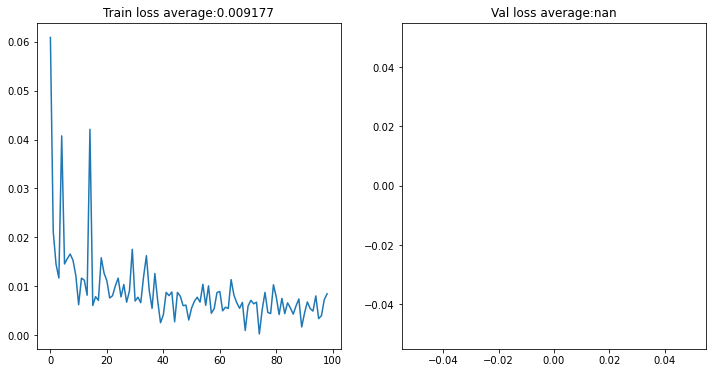

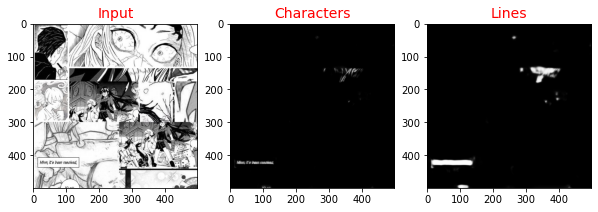

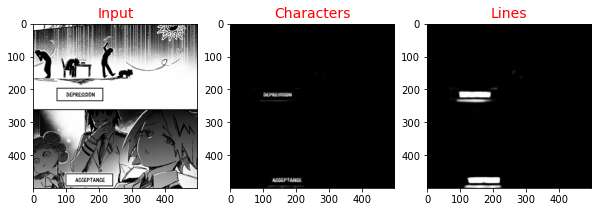

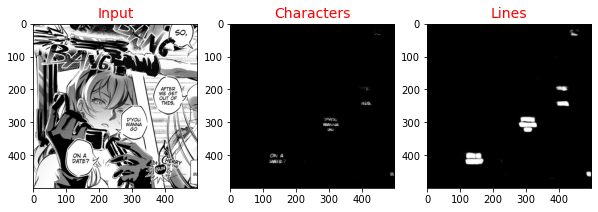

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s, train_loss=0.00124, validate_loss=0]


([0.06086048111319542,
  0.021170688793063164,
  0.01448157150298357,
  0.011693130247294903,
  0.0407462902367115,
  0.014568931423127651,
  0.015684129670262337,
  0.016589049249887466,
  0.015322958119213581,
  0.012211054563522339,
  0.006229151505976915,
  0.011666536331176758,
  0.011248885653913021,
  0.008176696486771107,
  0.04208569973707199,
  0.006078989244997501,
  0.007879517041146755,
  0.007123039104044437,
  0.01582689955830574,
  0.0127065759152174,
  0.011120940558612347,
  0.007604740560054779,
  0.008069437928497791,
  0.010087111964821815,
  0.011676213704049587,
  0.007831188850104809,
  0.010365921072661877,
  0.00675081554800272,
  0.009055647067725658,
  0.017559465020895004,
  0.0069862836971879005,
  0.007767188362777233,
  0.006651891395449638,
  0.011958860792219639,
  0.016252530738711357,
  0.009163453243672848,
  0.005489585921168327,
  0.012609872035682201,
  0.0070167225785553455,
  0.002553804311901331,
  0.004173620138317347,
  0.008753115311264992,

In [11]:
train(model,
      train_dataset=real_training_dataset,
      update_callback=save_and_report,
      update_every_n=10,
      validate_every_n=10,
      batch_size=5,
      epoch_count=20)